In [ ]:
import skimage


def mask_he_img(img):
    reversed_img = 255 - img
    reversed_img = reversed_img.max(axis=2)
    thresh = skimage.filters.threshold_triangle(
        reversed_img
    )
    in_tissue_mask = reversed_img > thresh
    return in_tissue_mask

In [ ]:
import tifffile

img = tifffile.imread('cropped_img.tif')
mask_img = mask_he_img(img)

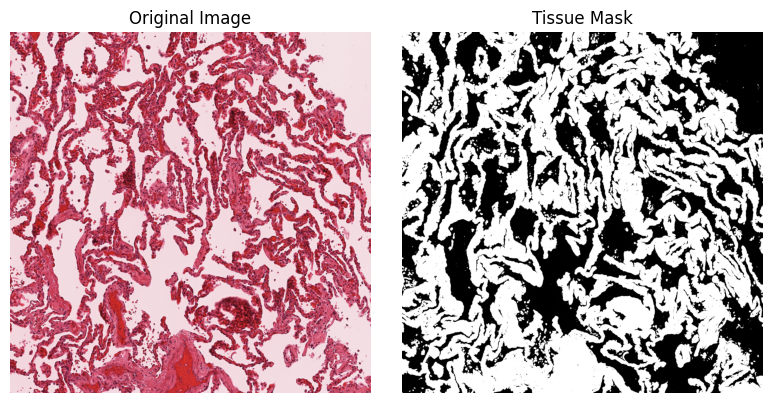

In [3]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(mask_img, cmap='gray')
ax[1].set_title('Tissue Mask')
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
import scipy
import numpy as np


def dilate_mask(
        mask,
        radius
    ):
    reversed_img = mask == 0

    distance, indices = scipy.ndimage.distance_transform_edt(
        reversed_img,
        return_distances=True,
        return_indices=True
    )

    within_radius = distance <= radius
    mask[
        within_radius
    ] = mask[
        indices[0][within_radius],
        indices[1][within_radius]
    ]
    return mask


def dilate_coords(
        spatial_coords,      # [[y, x], [y, x], ...]
        labels,
        radius: int,
        data_type=np.uint16,
    ):
    assert spatial_coords.dtype == 'int'
    assert spatial_coords.shape[0] == labels.shape[0]

    ## prepare blank img frame from spatial coords
    mask = np.zeros(
        shape=spatial_coords.max(axis=0) + 1,
        dtype=data_type
    )
    mask[spatial_coords[:, 0], spatial_coords[:, 1]] = labels
    
    mask = dilate_mask(
        mask,
        radius
    )
    return mask[spatial_coords[:, 0], spatial_coords[:, 1]]

In [11]:
dilated_masks = dilate_mask(
    mask_img.copy(),
    radius=10,
)

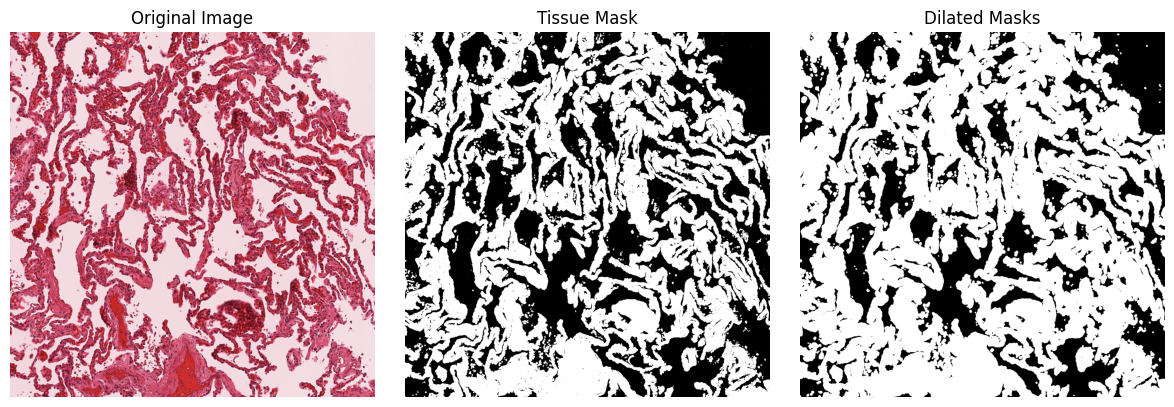

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(mask_img, cmap='gray')
ax[1].set_title('Tissue Mask')
ax[1].axis('off')

ax[2].imshow(dilated_masks, cmap='gray')
ax[2].set_title('Dilated Masks')
ax[2].axis('off')

plt.tight_layout()
plt.savefig('tissue_segmentation_and_dilation.png', dpi=200)
plt.show()